# Manual storm-centering code for WoFS ESA

This code allows full visualization and centering of WoFS mesocyclones with some external need for an Excel/Google Sheets spreadsheet. The end result is a time sequence of storm-centered WoFS files. 

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import skimage
import glob
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import centered_response as cr
from wofunits import wofunits


# Grab file paths
wofs_path = wofunits.paths['wofs_path']
mrms_path = wofunits.paths['mrms_data_path']
wofs_locs_path = wofunits.paths['wofs_locs_path']
mrms_locs_path = wofunits.paths['mrms_locs_path']

# Grab mapping paths
shapefiles = wofunits.mapping['shapefiles']
edgecolor = wofunits.mapping['edgecolor']
lw = wofunits.mapping['lw']

# Find maxima and write maxima to file by case

The code in this section finds 20 local maxima of mid-level updraft helicity as candidates for the mesocyclone of interest. These maxima will be manually analyzed to identify that desired mesocyclone. This code returns netCDF files with dimensions num_times x maxima, so num_times x 20.

## Select desired case 

In [2]:
case = '201905172200' # string w/ format 'YYYYmmddHHMM'

#### Shouldn't have to touch anything in this cell

In [3]:
# Select index specs

if case == '201905172200':
    idx_ns = 120,235
    idx_we = 100,200
    files_idxs = 1,-1 # indices in file list that cover analyzed WoFS times
    mrms_idxs = 67,101 # indices in MRMS file list that cover analyzed WoFS times (w/ 10-min buffer)
    df_idx = -2 # end index of df_displace
    
if case == '201905202030':
    idx_ns = 135,195
    idx_we = 60,160
    files_idxs = 1,-10
    mrms_idxs = 48,76
    df_idx = -2
    
if case == '201905262000':
    idx_ns = 150,250
    idx_we = 40,140
    files_idxs = 0,-12
    mrms_idxs = 0,999
    df_idx = -8
    
if case == '201905282230':
    idx_ns = 150,250
    idx_we = 10,110
    files_idxs = 1,-4
    mrms_idxs = 72,105
    df_idx = -2

# Index WoFS and MRMS files by range of analysis times
files_wofs = sorted(glob.glob(f'{wofs_path}/wofs_{case[:8]}_{case[8:]}/wofs_i*'))[files_idxs[0]:files_idxs[1]]
files_mrms = sorted(glob.glob(f'{mrms_path}/MRMS_{case[:8]}/wofs*.nc'))[mrms_idxs[0]:mrms_idxs[1]]

# Create 15-min incremented file list for saving centered output
files_15min = files_wofs[files_idxs[0]:files_idxs[1]]
files_15min = [file for file in files_15min if any(ext in file for ext in ['00.nc','15.nc','30.nc','45.nc'])]

## Find n largest maxima and write nx, ny indices to file

In [4]:
n = 20 # set number of maxima to identify

####### Shouldn't have to touch anything below here #########

maxima_times = []
times = []
for i in range(len(files_wofs)):
        
    ds = xr.open_dataset(files_wofs[i])
    
    time = ds['XTIME'][0,0].values
    
    maxima_mems = []
    for j in range(36):
        uh_5min = ds['UP_HELI_MAX'][j,0,idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
        lat = ds['XLAT'][0,0,idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
        lon = ds['XLONG'][0,0,idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
        # returned points are sorted high to low from max to threshold
        maxima = skimage.feature.peak_local_max(uh_5min, min_distance=1, num_peaks=n)
        
        maxima_mems.append(maxima)
        
    times.append(time)
    maxima_times.append(maxima_mems)

times = np.array(times)
maxima_times = np.array(maxima_times)

maxima_times_swap = np.swapaxes(maxima_times, 0, 1)

ds_new = xr.Dataset({'maxima_indices': xr.DataArray(data = maxima_times_swap,
                                                    dims = ['Member', 'Time', 'Maxima_num', 'XY']),
                    
                     'time': xr.DataArray(data = times,
                                          dims = 'Time') 
                    },
                    
                   attrs = {'NS_displacement': idx_ns[0],
                            'EW_displacement': idx_we[0]} )


ds_new.to_netcdf(f'{wofs_locs_path}/maxima_indices_{case[5:8]}_{case[-4:]}')


## Manually interrogate WoFS forecast mesocyclone coordinates

Manually set time and member indices, then ingest netCDF files to sort through maxima indices to find that corresponding to the desidred mesocyclone. Record the (ny,nx) indices in this Google Spreadsheet: https://docs.google.com/spreadsheets/d/1kIW24EVI_o40y6qxK9ShlL2XmAo61mRtvB2RgrkIqDM/edit#gid=0h

NOTE: If sorting 15-minute intervals, multiply time_idx by 3 in the first cell of this sequence. If 5-minute intervals, then multiply by 1 or simply comment out the multiplication statement.

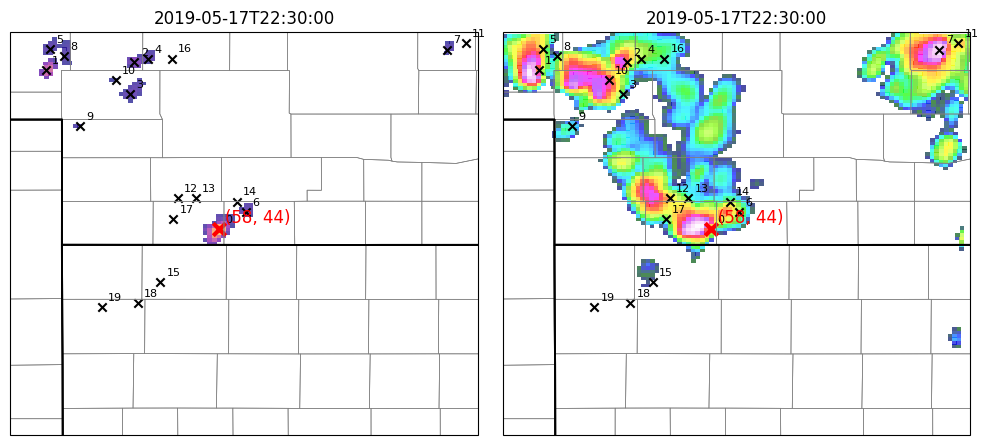

In [5]:
# Use time_idx and mem_idx to manually interrogate maxima across times to find coordinates of target mesocyclone

time_idx = 1 # index in WoFS file list
mem_idx = 35 # member index in WoFS file at time_idx
test_idx = 0 # maxima indices in descending order of UH magnitude (adjust until target mesocyclone found)

########## Shouldn't have to touch anything below here #################################################

file = files_wofs[time_idx]

ds_wofs = xr.open_dataset(file)
cref = ds_wofs['REFD_MAX'][mem_idx,0,idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
cref = np.where(cref >= 10, cref, np.nan)
uh = ds_wofs['UP_HELI_MAX'][mem_idx,0,idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
uh = np.where(uh >= 10, uh, np.nan)
lat = ds_wofs['XLAT'][0,0,idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
lon = ds_wofs['XLONG'][0,0,idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values

ds_maxima = xr.open_dataset(f'{wofs_locs_path}/maxima_indices_{case[5:8]}_{case[-4:]}')
time_maxima = ds_maxima['time'][time_idx].values
poss_maxima = ds_maxima['maxima_indices'][mem_idx, time_idx].values

#################################### Plot ############################################################

fig, axs = plt.subplots(1,2,figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(['k'])

# Contourfill variables and cmaps to iterate through
cfvars = [uh,cref]
cmaps = ['plasma', 'gist_ncar']

# Iterate over subplots
for i, ax in enumerate(axs):

    # Plot contourfill
    cf = ax.pcolormesh(lon, lat, cfvars[i], cmap=cmaps[i],
                     alpha=0.7, transform=ccrs.PlateCarree())

    # Plot all maxima indices
    ax.scatter(lon[poss_maxima[:,0], poss_maxima[:,1]], lat[poss_maxima[:,0], poss_maxima[:,1]], 
               transform=ccrs.PlateCarree(), marker='x', c='k')

    # Annotate all maxima indices
    for i in range(len(poss_maxima)):
        ax.annotate(i, 
                (lon[poss_maxima[i,0], poss_maxima[i,1]]+0.05, lat[poss_maxima[i,0], poss_maxima[i,1]]+0.05),
               transform=ccrs.PlateCarree(), size=8, c='k')

    # Plot selected maximum
    ax.scatter(lon[poss_maxima[test_idx,0], poss_maxima[test_idx,1]], lat[poss_maxima[test_idx,0], poss_maxima[test_idx,1]], 
               transform=ccrs.PlateCarree(), marker='x', s=80, linewidth=3, c='r')

    # Annotate selected maximum
    ax.annotate((poss_maxima[test_idx,0], poss_maxima[test_idx,1]), 
                (lon[poss_maxima[test_idx,0], poss_maxima[test_idx,1]]+0.05, lat[poss_maxima[test_idx,0], poss_maxima[test_idx,1]]+0.05),
               transform=ccrs.PlateCarree(), size=12, c='r')

    # Plot shapefiles
    for j in range(len(shapefiles)):
        reader = shpreader.Reader(shapefiles[j])
        vector_data = list(reader.geometries())
        VECTOR_DATA = cfeature.ShapelyFeature(vector_data, ccrs.PlateCarree())
        ax.add_feature(VECTOR_DATA, facecolor='none', edgecolor = edgecolor[j], lw = lw[j])

    ax.set_title(str(time_maxima)[:-10])

plt.tight_layout()

In [6]:
# to quickly sort through indices
test_idx = 3

# Determine observed mesocyclone coordinates via MRMS 

Find local maxima as with WoFS members and save to netCDF file. Then manually sort through these maxima and record the (ny,nx) coordinates in the same spreadsheet.

### Identify MRMS azimuthal wind shear maxima and write nx,ny indices to file

In [9]:
n=8 # set number of maxima to identify

maxima_times = []
times = []
for i in range(len(files_mrms)):
    
    ds = xr.open_dataset(files_mrms[i])
    
    time_str = files_mrms[i][-16:-3]
    
    time = datetime.datetime(year=int(time_str[:4]),
                             month=int(time_str[4:6]),
                             day=int(time_str[6:8]),
                             hour=int(time_str[9:11]),
                             minute=int(time_str[11:13]))

    aws = ds['aws_mid_cress'][idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
    lat = ds['lat'][idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
    lon = ds['lon'][idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
    
    # returned points are sorted high to low from max to threshold
    maxima_time = skimage.feature.peak_local_max(aws, min_distance=1, num_peaks=n)
    
    maxima_times.append(maxima_time)
    times.append(time)

times = np.array(times)
maxima_times = np.array(maxima_times)

ds_maxima_mrms = xr.Dataset({'maxima_indices': xr.DataArray(data = maxima_times,
                                                    dims = ['Time', 'Maxima_num', 'XY']),
                    
                     'time': xr.DataArray(data = times,
                                          dims = 'Time') 
                     },
                    
                   attrs = {'NS_displacement': idx_ns[0],
                            'EW_displacement': idx_we[0]} )

# Save to file
ds_maxima_mrms.to_netcdf(f'{mrms_locs_path}/mrms_maxima_indices_{case[5:8]}')

## Manually interrogate MRMS mesocyclone coordinates

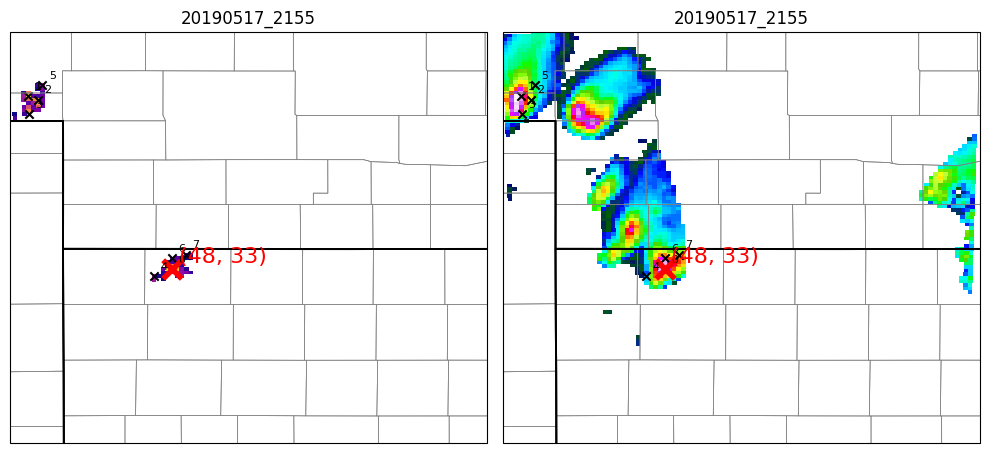

In [10]:
time_idx = 1 # index in MRMS file list
test_idx = 0 # maxima indices in descending order of AWS magnitude (adjust until target mesocyclone found)

################# Shouldn't have to touch anything below ##########################################

ds_mrms = xr.open_dataset(files_mrms[time_idx])
ds_maxima_mrms = xr.open_dataset(f'{mrms_locs_path}/mrms_maxima_indices_{case[5:8]}')

poss_maxima = ds_maxima_mrms['maxima_indices'][time_idx].values

cref = ds_mrms['dz_cress'][idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
cref = np.where(cref >= 10, cref, np.nan)
aws = ds_mrms['aws_mid_cress'][idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
aws = np.where(aws > 0.0005, aws, np.nan)
lat = ds_mrms['lat'][idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values
lon = ds_mrms['lon'][idx_ns[0]:idx_ns[1],idx_we[0]:idx_we[1]].values

#################################### Plot ############################################################

fig, axs = plt.subplots(1,2,figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(['k'])

# Contourfill variables and cmaps to iterate through
cfvars = [aws,cref]
cmaps = ['plasma', 'gist_ncar']

# Iterate over subplots
for i, ax in enumerate(axs):

    # Plot contourfill
    ax.pcolormesh(lon, lat, cfvars[i], transform=ccrs.PlateCarree(), cmap=cmaps[i])

    # Plot all maxima
    ax.scatter(lon[poss_maxima[:,0], poss_maxima[:,1]], lat[poss_maxima[:,0], poss_maxima[:,1]], 
                transform=ccrs.PlateCarree(), marker='x', c='k')

    # Plot selected maximum
    ax.scatter(lon[poss_maxima[test_idx,0], poss_maxima[test_idx,1]], lat[poss_maxima[test_idx,0], poss_maxima[test_idx,1]], 
                transform=ccrs.PlateCarree(), marker='x', s=180, linewidth=4, c='r')

    # Annotate all maxima
    for j in range(len(poss_maxima)):
        ax.annotate(j, 
                (lon[poss_maxima[j,0], poss_maxima[j,1]]+0.05, lat[poss_maxima[j,0], poss_maxima[j,1]]+0.05),
               transform=ccrs.PlateCarree(), size=8, c='k')

    # Annotate selected maximum
    ax.annotate((poss_maxima[test_idx,0], poss_maxima[test_idx,1]), 
                (lon[poss_maxima[test_idx,0], poss_maxima[test_idx,1]]+0.05, lat[poss_maxima[test_idx,0], poss_maxima[test_idx,1]]+0.05), 
               transform=ccrs.PlateCarree(), size=16, c='r')

    # Plot shapefiles
    for j in range(len(shapefiles)):
        reader = shpreader.Reader(shapefiles[j])
        vector_data = list(reader.geometries()) 
        VECTOR_DATA = cfeature.ShapelyFeature(vector_data, ccrs.PlateCarree())
        ax.add_feature(VECTOR_DATA, facecolor='none', edgecolor = edgecolor[j], lw = lw[j])

    # Set title
    ax.set_title(files_mrms[time_idx][-16:-3])

plt.tight_layout()

In [11]:
test_idx = 0 # to easily sift through maxima indices

## Format manually tracked storm centers from CSV

Create pandas dataframes that allow matrix operations to be performed on WoFS datasets. Ingests csv files from downloaded Google Spreadsheet: https://docs.google.com/spreadsheets/d/1kIW24EVI_o40y6qxK9ShlL2XmAo61mRtvB2RgrkIqDM/edit#gid=0.

In [14]:
#%%capture --no-stdout

######## Shouldn't have to touch anything in this cell ###########

# Manipulate pandas dataframe from csv to proper format that separates ny and ny coordinates into separate columns

if '20190517' in case:
    df_center = pd.read_csv(f'{wofs_locs_path}/max_gridpoint_storm_centering_{case}.csv', header=0)
else:
    df_center = pd.read_csv(f'{wofs_locs_path}/max_gridpoint_storm_centering_{case[:8]}.csv', header=0)
    
ds_maxima_mrms = xr.open_dataset(f'{mrms_locs_path}/mrms_maxima_indices_{case[5:8]}')

valid_times = df_center.columns.values.tolist()[1:]

df_center = df_center.rename(columns={'Unnamed: 0': 'Member'}).set_index('Member')

for i in range(len(valid_times)):
    col = df_center.iloc[:,i].str.replace('(', '').str.replace(')', '')
    col = col.apply(lambda x: pd.Series(str(x).split(',')))
    col = col.rename(columns={0:f'{valid_times[i]} nx',
                              1:f'{valid_times[i]} ny'})
    
    df_center = pd.merge(df_center, col, on='Member')
    
df_center = df_center.iloc[:,len(valid_times):].astype(int)


df_nx = df_center.iloc[:,1::2] + ds_maxima_mrms.attrs['EW_displacement']
df_ny = df_center.iloc[:,0::2] + ds_maxima_mrms.attrs['NS_displacement']

df_center = pd.concat([df_ny, df_nx], axis=1)
df_center = df_center[list(sum(zip(df_ny.columns, df_nx.columns), ()))]


# Subtract MRMS gridpoint coordinates from WoFS member coordinates.
# Returns displacement vector between MRMS and WoFS storm centers
df_displace = df_center[:-1] - df_center[-1:].values[0]

# Crop dataframe to only analysis times 
df_displace = df_displace.iloc[:,:df_idx] 

## Plot all member storm tracks for sanity check

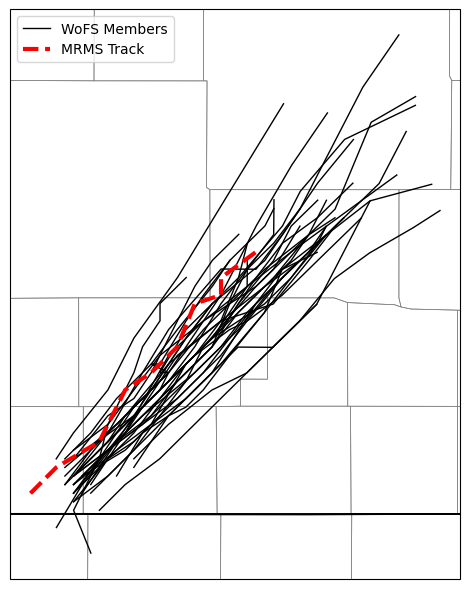

In [15]:

######## Shouldn't have to touch anything in this cell ###########

ds_mrms = xr.open_dataset(f'{mrms_path}/MRMS_{case[:8]}/wofs_MRMS_RAD_{case[:8]}_2235.nc')
lat = ds_mrms['lat'].values
lon = ds_mrms['lon'].values


fig = plt.figure(figsize=(6,6))

ax = plt.subplot(1,1,1,projection=ccrs.Mercator())

for i in range(36):
        # if statement to allow only one legend instance for WoFS tracks
    if i == 0:
        ax.plot(lon[df_center.iloc[i,2::2].values[:-1], df_center.iloc[i,3::2].values[:-1]], 
                lat[df_center.iloc[i,2::2].values[:-1], df_center.iloc[i,3::2].values[:-1]], 
                c='k', transform=ccrs.PlateCarree(), lw=1)
    else:
        ax.plot(lon[df_center.iloc[i,2::2].values[:-1], df_center.iloc[i,3::2].values[:-1]], 
                lat[df_center.iloc[i,2::2].values[:-1], df_center.iloc[i,3::2].values[:-1]], 
                label='_nolegend_', c='k', transform=ccrs.PlateCarree(), lw=1)
        
ax.plot(lon[df_center.iloc[:,2::2].values[-1],df_center.iloc[:,3::2].values[-1]],
        lat[df_center.iloc[:,2::2].values[-1],df_center.iloc[:,3::2].values[-1]],
        c='r', lw=3, ls='--', transform=ccrs.PlateCarree())

for j in range(len(shapefiles)):
    reader = shpreader.Reader(shapefiles[j])
    vector_data = list(reader.geometries()) 
    VECTOR_DATA = cfeature.ShapelyFeature(vector_data, ccrs.PlateCarree())
    ax.add_feature(VECTOR_DATA, facecolor='none', edgecolor = edgecolor[j], lw = lw[j])

#ax.set_extent([-102.5, -96.5, 32.5, 37.1], crs=ccrs.PlateCarree())

#ax.pcolormesh(lon, lat, ds_mrms['aws_mid_cress'], transform=ccrs.PlateCarree())

plt.legend(['WoFS Members', 'MRMS Track'])

plt.tight_layout()

# Use centers to composite all members to common grid

## Now crop 300x300 gridpoint domains to 240x240 centered on the MRMS observed supercell, then save to netCDF file.

This centers WoFS member mesocyclones onto the location of the observed MRMS storm. To do this, the WoFS domain is cropped (sliced) to the same dimensions about different indices depending on the MRMS-WoFS displacement vector.

NetCDF files are then written in the same format as processed WoFS files but with different (smaller) dimensions.

In [16]:
# Use displacement coordinates and iterate through time and members, saving a file for each timestep

# Gridpoints around each edge to cut off
buffer = 30 

print('Initiating file save.\n')

    # iterate through time
for i, (nxcol, nycol) in enumerate(zip(df_displace.columns[2::2], df_displace.columns[3::2])):
    
    ds_wofs = xr.open_dataset(files_15min[i])
    
    nx_displ = df_displace[nxcol].values
    ny_displ = df_displace[nycol].values

    # iterate through members
    dslist_mem = []
    for j in range(36):
        ds_iter = ds_wofs.isel(Member=j, south_north=slice(buffer+1+nx_displ[j],300-buffer+1+nx_displ[j]),
                                         west_east=slice(buffer+1+ny_displ[j],300-buffer+1+ny_displ[j]))
        
        dslist_mem.append(ds_iter)
        
    ds_concat = xr.concat(objs=dslist_mem, dim='Member')
    
    ds_concat.attrs['CENTER_NY'] = df_center.tail(1)[nxcol].values[0] - (buffer)
    ds_concat.attrs['CENTER NX'] = df_center.tail(1)[nycol].values[0] - (buffer)

    # save
    print(f'Writing file for {nxcol[:8]}.')
    
    ds_concat.to_netcdf(path=files_15min[0][:-30] + 'center_' + files_15min[0][-30:])
    
    print(f'File for {nxcol[:8]} written.')
    
print('\nFile saving complete.')

Initiating file save.

Writing file for 2230 UTC.
File for 2230 UTC written.
Writing file for 2245 UTC.
File for 2245 UTC written.
Writing file for 2300 UTC.
File for 2300 UTC written.
Writing file for 2315 UTC.
File for 2315 UTC written.
Writing file for 2330 UTC.
File for 2330 UTC written.
Writing file for 2345 UTC.
File for 2345 UTC written.
Writing file for 0000 UTC.
File for 0000 UTC written.
Writing file for 0015 UTC.
File for 0015 UTC written.
Writing file for 0030 UTC.
File for 0030 UTC written.

File saving complete.


## Manually inspect centered files

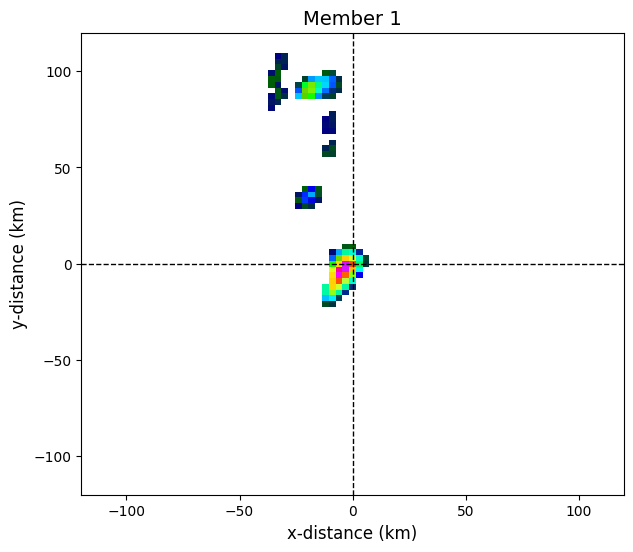

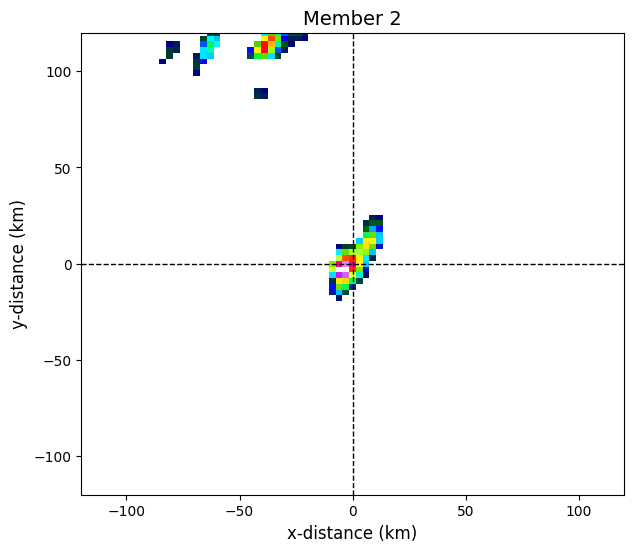

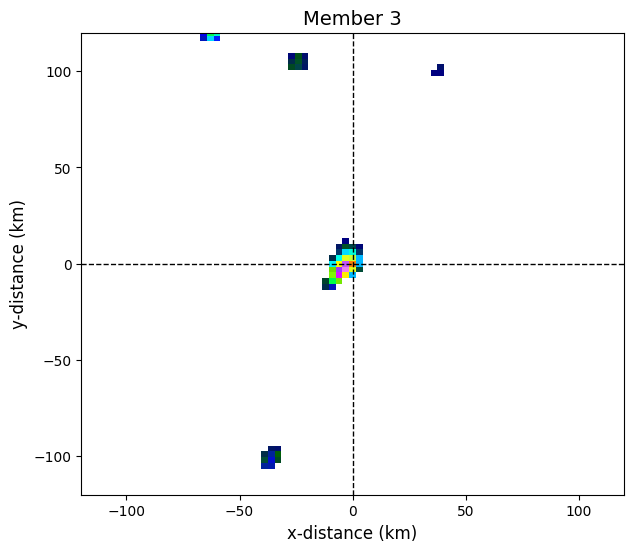

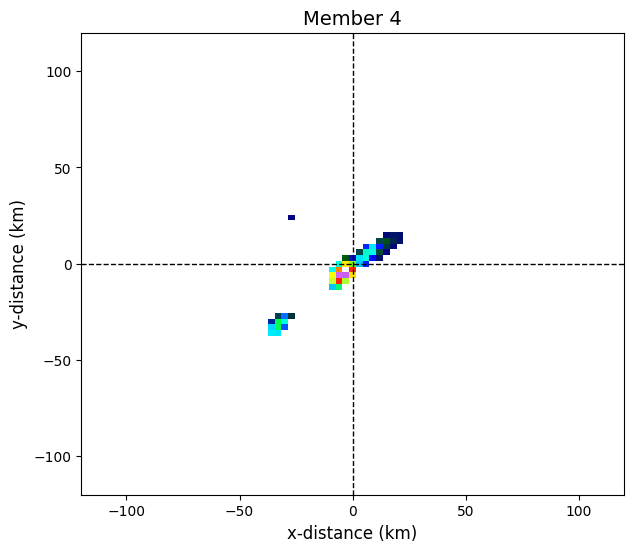

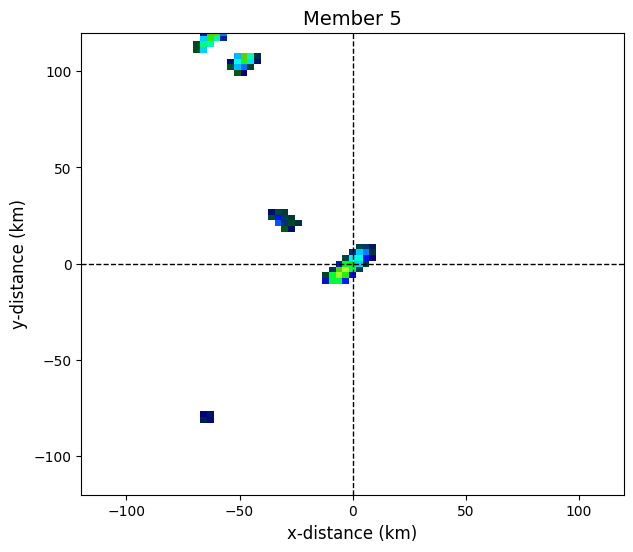

In [17]:
# Plot to manually inspect

files_centered = sorted(glob.glob(f'{wofs_path}/wofs_{case[:8]}_{case[8:]}/wofs_center_i*'))

for file in files_centered[2:3]:
    
    ds = xr.open_dataset(file)
    
    for i in range(36)[0:5]:
        fig = plt.figure(figsize=(7,6))
        
        pcmvar = np.where(ds['UP_HELI_MAX'][i,0]>10, ds['UP_HELI_MAX'][i,0], np.nan)

        xmesh, ymesh = cr.xy_mesh(case, state_time=datetime.datetime.strptime(file[-15:-3], '%Y%m%d%H%M'))
        
        plt.pcolormesh(xmesh, ymesh, pcmvar, cmap='gist_ncar')

        plt.axhline(y=0, ls='--', lw=1, c='k')
        plt.axvline(x=0, ls='--', lw=1, c='k')

        plt.xlabel('x-distance (km)', size=12)
        plt.ylabel('y-distance (km)', size=12)
        plt.title(f'Member {i+1}', size=14)
        
        plt.xlim(-120,120)
        plt.ylim(-120,120)
        #plt.savefig(f'{file[-7:-3]}utc_mem{i}_ref.jpg')